REVENUE FORECASTING WITH ARIMA
EXTRACTING DATA FROM EXCEL
File: Richspread.xlsx
Sheet: Revenue_Step
Date Range: B4:U4
Revenue Range: B5:U5
Extracted 20 date entries and 20 revenue entries

Successfully processed data:
Date range: 2006-01-31 to 2025-01-31
Total data points: 20
Revenue range: $8,582,237,000 to $40,612,308,000
Data prepared: 17 training samples, 3 test samples

Checking stationarity of the data:
ADF Statistic: -0.370052
p-value: 0.914980
Critical Values:
	1%: -4.012
	5%: -3.104
	10%: -2.691
Series is non-stationary at 0.05 significance level

Plotting diagnostic charts:


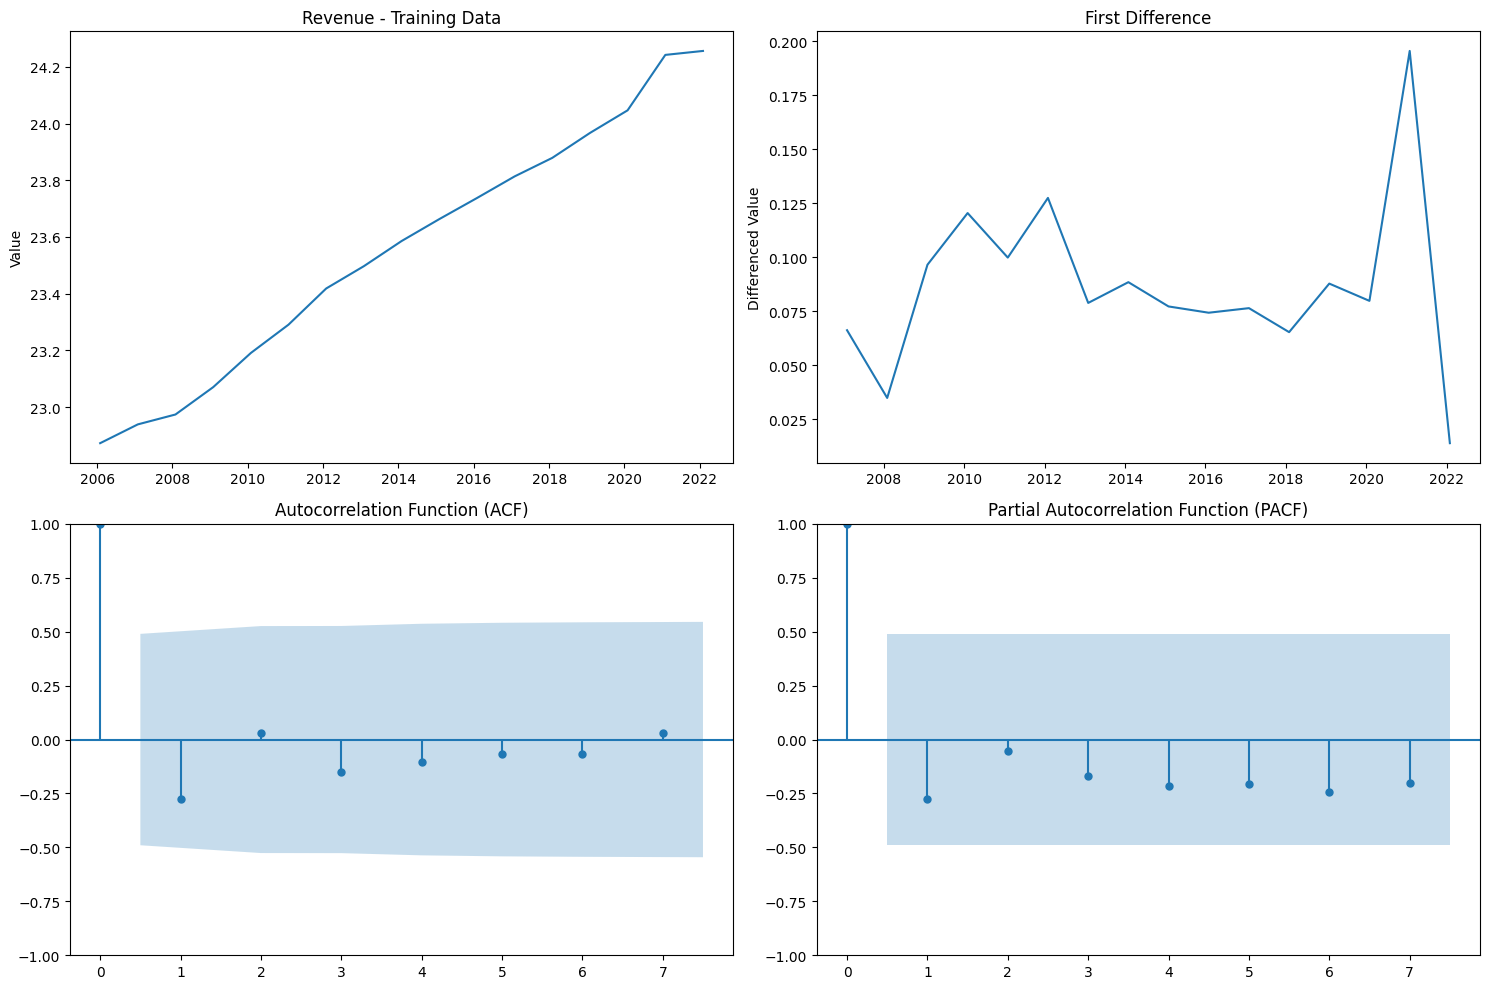


Searching for optimal ARIMA parameters...
Performing grid search for optimal ARIMA parameters...
Progress: 5/48 combinations tested
Progress: 10/48 combinations tested
Progress: 15/48 combinations tested
Progress: 20/48 combinations tested
Progress: 25/48 combinations tested
Progress: 30/48 combinations tested
Progress: 35/48 combinations tested
Progress: 40/48 combinations tested
Progress: 45/48 combinations tested
Progress: 48/48 combinations tested

Best ARIMA order: (1, 1, 1)
Best AIC: -47.1203

Generating forecasts for test period...

Evaluating model performance...
Model Evaluation Metrics:
MAPE: 5.07%
RMSE: 2359116619.5555
MAE: 2015051764.8252

Plotting results...


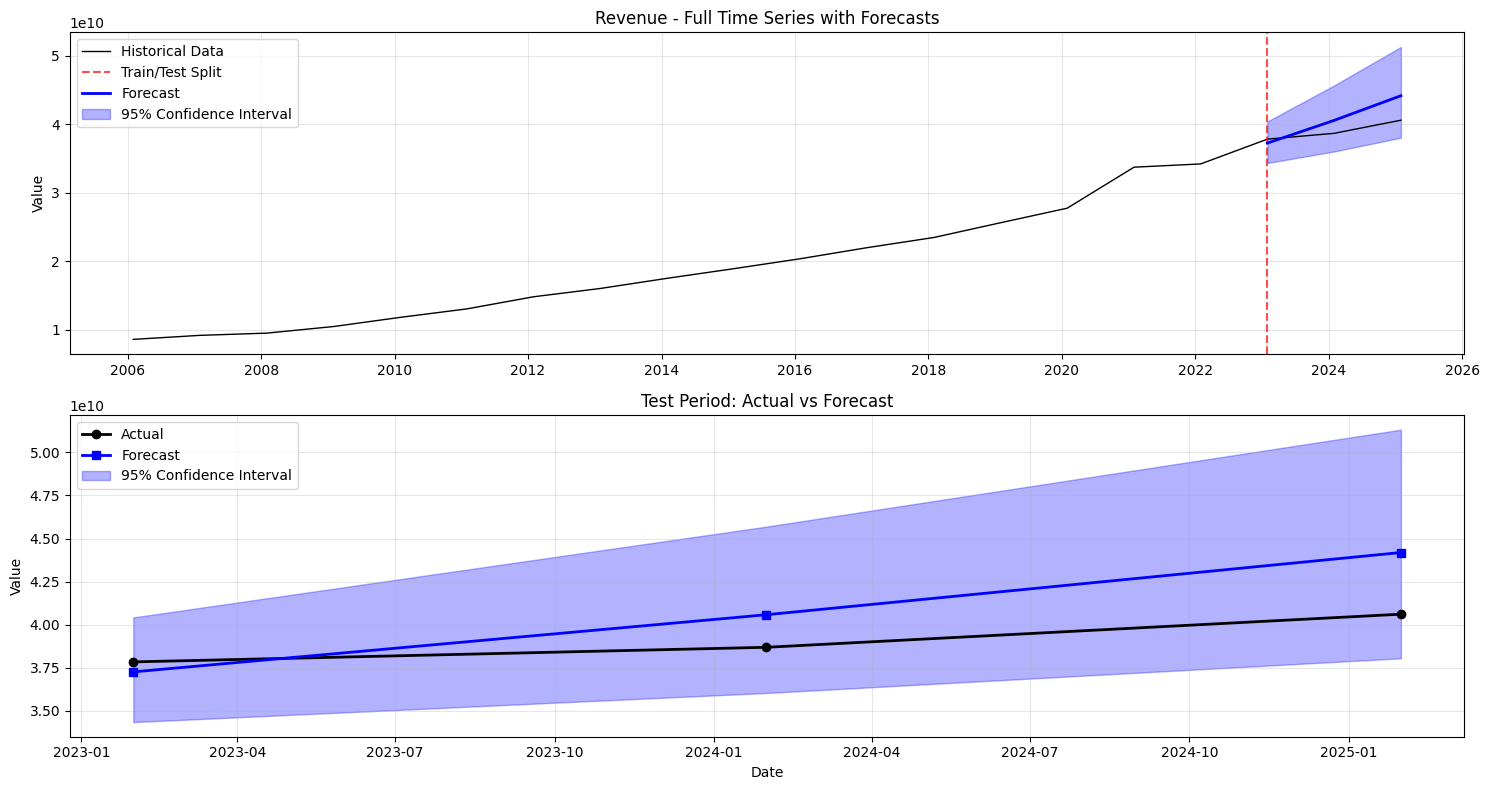


Generating residual diagnostic plots...
Generating residual diagnostic plots for ARIMA(1, 1, 1) model...


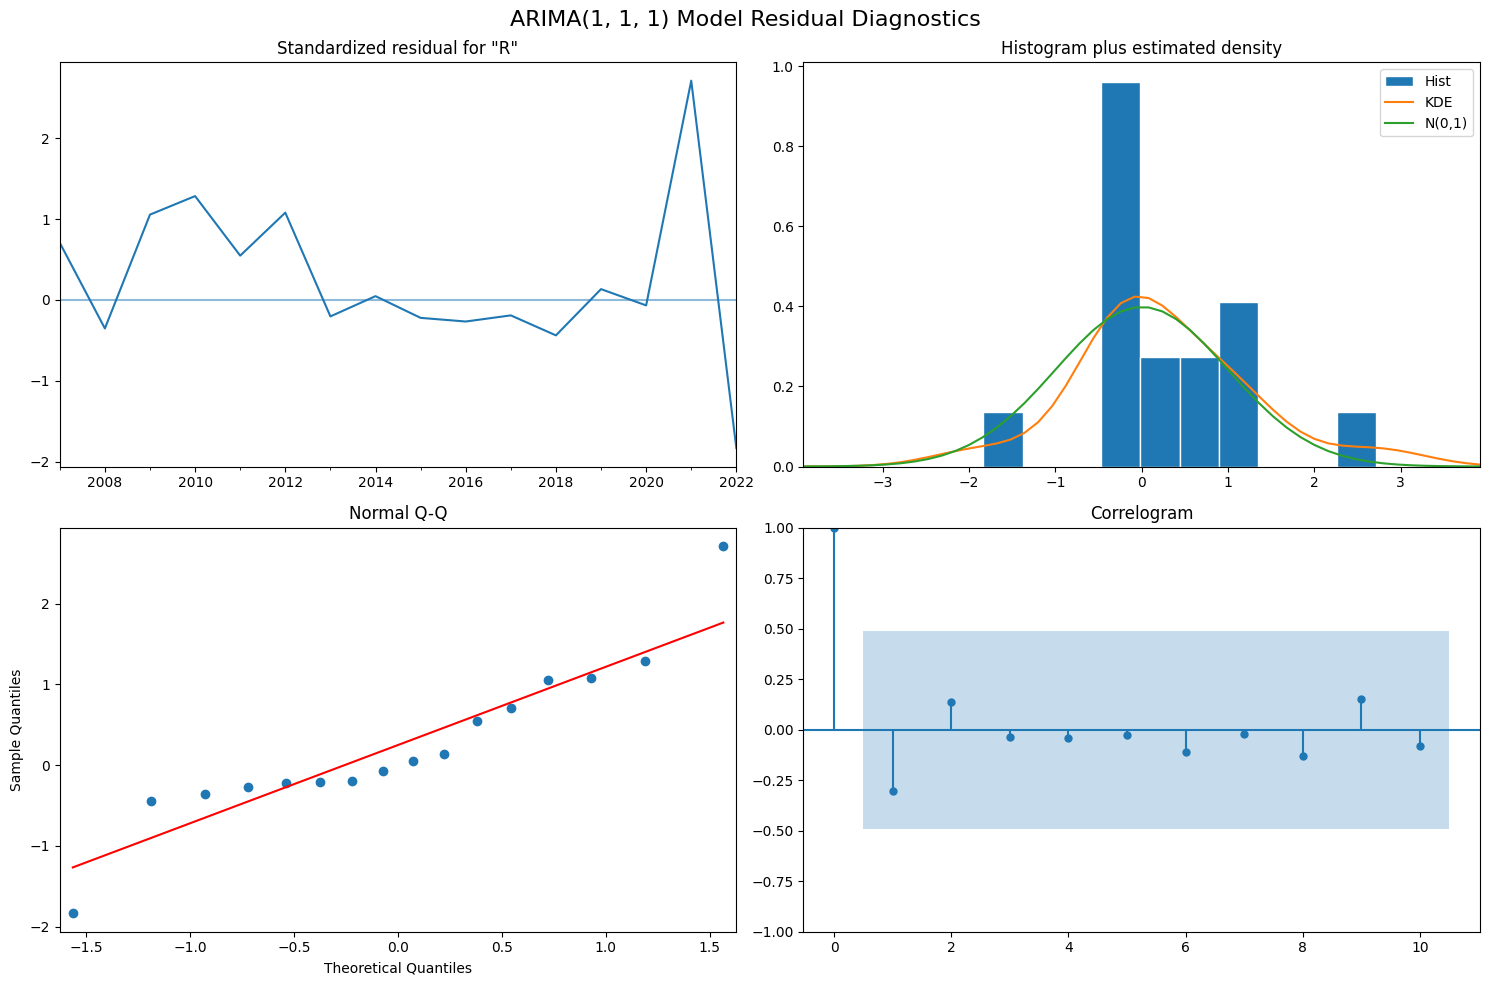

✓ Statsmodels diagnostic plots generated successfully

Generating residuals vs fitted values plot...


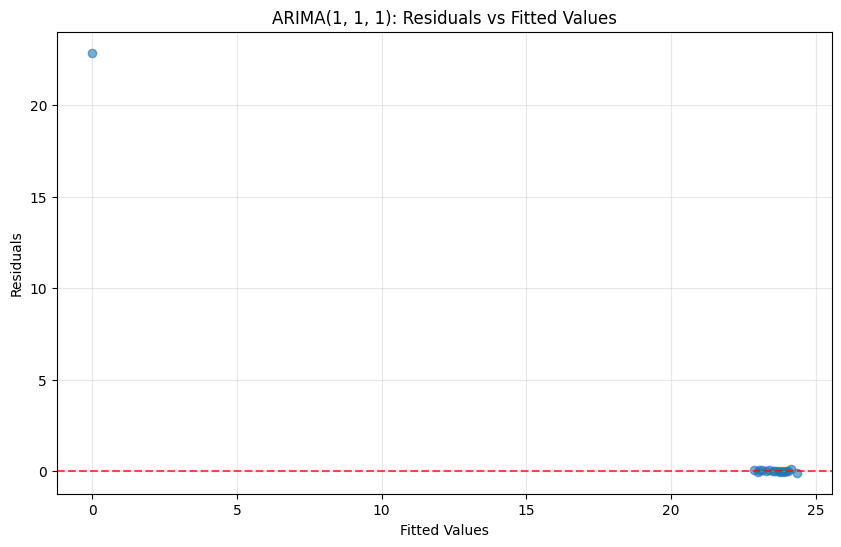


Performing comprehensive residual analysis...

COMPREHENSIVE RESIDUAL ANALYSIS

1. AUTOCORRELATION TESTS
------------------------------
Ljung-Box Test Results:
  Significant autocorrelation detected: No

2. NORMALITY TEST (Shapiro-Wilk only)
-----------------------------------
Shapiro-Wilk Test:
  Statistic: 0.2688, P-value: 0.0000
  Residuals are normal: No

3. HETEROSKEDASTICITY TESTS
------------------------------
Breusch-Pagan Test:
  Statistic: 2.8333, P-value: 0.0923
  Constant variance: Yes
Variance Stability Check:
  First half variance: 57.0652
  Second half variance: 0.0021
  Variance ratio: 26650.46
  Variance is stable: No

4. OVERALL RESIDUAL ASSESSMENT
-----------------------------------
⚠ Issues detected with model residuals:
  - Non-normal residuals
  - Unstable variance

Recommendations:
  • Consider Box-Cox transformation
  • Check for outliers and structural breaks
  • Consider robust estimation methods
  • Consider GARCH modeling for volatility
  • Apply variance s

In [22]:
import xlwings as xw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.tsa.seasonal import STL
from scipy import stats
from scipy.stats import shapiro, probplot
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from typing import Optional, Tuple, Dict, List
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# INPUTS 
EXCEL_FILE_PATH = 'Richspread.xlsx'           
SHEET_NAME = 'Revenue_Step'                  
DATE_RANGE = 'B4:U4'                          
REVENUE_RANGE = 'B5:U5'                      
START_DATE = None                            

# Forecasting Parameters
TEST_PERIODS = 3                             
FUTURE_FORECAST_PERIODS = 8                  
AUTO_SELECT_PARAMETERS = True               
APPLY_LOG_TRANSFORMATION = True            

# Date Format 
DATE_FORMAT = '%d/%m/%Y'                   

class ARIMAForecaster:
    """
    A reusable ARIMA model class for time series forecasting.
    """
    def __init__(self, data: pd.Series, target_column: str = None):
        if isinstance(data, pd.DataFrame):
            if target_column is None:
                raise ValueError("target_column must be specified for DataFrame input")
            self.data = data[target_column].copy()
            self.target_column = target_column
        else:
            self.data = data.copy()
            self.target_column = data.name or 'target'
        self.original_data = self.data.copy()
        self.model = None
        self.best_order = None
        self.train_data = None
        self.test_data = None
        self.predictions = None
        self.forecast_results = None
        self.log_transformed = False

    def prepare_data(self, start_date: str = None, end_date: str = None, 
                    test_size: int = 12, apply_log: bool = True):
        # Filter data by date range if specified
        if start_date or end_date:
            self.data = self.data.loc[start_date:end_date]
        # Handle test_size being larger than available data
        if test_size >= len(self.data):
            test_size = max(1, len(self.data) // 4)
            print(f"Warning: test_size adjusted to {test_size} (25% of available data)")
        # Split into train and test sets
        if test_size == 0:
            self.train_data = self.data.copy()
            self.test_data = pd.Series(dtype=float)
        else:
            self.train_data = self.data.iloc[:-test_size].copy()
            self.test_data = self.data.iloc[-test_size:].copy()
        # Apply log transformation if specified
        if apply_log and len(self.train_data) > 0:
            self.train_data = np.log(self.train_data + 1e-8)
            self.log_transformed = True
        else:
            self.log_transformed = False
        print(f"Data prepared: {len(self.train_data)} training samples, {len(self.test_data)} test samples")
        return self

    def check_stationarity(self, series: pd.Series = None, alpha: float = 0.05) -> bool:
        if series is None:
            series = self.train_data
        if len(series.dropna()) < 3:
            print("Warning: Not enough data points for stationarity test")
            return False
        result = adfuller(series.dropna())
        print(f'ADF Statistic: {result[0]:.6f}')
        print(f'p-value: {result[1]:.6f}')
        print('Critical Values:')
        for key, value in result[4].items():
            print(f'\t{key}: {value:.3f}')
        is_stationary = result[1] <= alpha
        print(f'Series is {"stationary" if is_stationary else "non-stationary"} at {alpha} significance level')
        return is_stationary

    def plot_diagnostics(self, series: pd.Series = None, lags: int = 20):
        if series is None:
            series = self.train_data.dropna()
        max_lags = min(lags, len(series) // 2 - 1)
        if max_lags < 1:
            print("Warning: Not enough data for diagnostic plots")
            return None
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes[0, 0].plot(series)
        axes[0, 0].set_title(f'{self.target_column} - Training Data')
        axes[0, 0].set_ylabel('Value')
        diff_series = series.diff().dropna()
        if len(diff_series) > 0:
            axes[0, 1].plot(diff_series)
            axes[0, 1].set_title('First Difference')
            axes[0, 1].set_ylabel('Differenced Value')
            try:
                sm.graphics.tsa.plot_acf(diff_series, lags=max_lags, ax=axes[1, 0])
                axes[1, 0].set_title('Autocorrelation Function (ACF)')
            except:
                axes[1, 0].text(0.5, 0.5, 'ACF plot failed', ha='center', va='center')
            try:
                sm.graphics.tsa.plot_pacf(diff_series, lags=max_lags, ax=axes[1, 1])
                axes[1, 1].set_title('Partial Autocorrelation Function (PACF)')
            except:
                axes[1, 1].text(0.5, 0.5, 'PACF plot failed', ha='center', va='center')
        plt.tight_layout()
        plt.show()
        return fig

    def plot_residual_diagnostics(self, figsize: Tuple[int, int] = (15, 10)):
        """
        Plot comprehensive residual diagnostics using both custom plots and statsmodels built-in diagnostics
        """
        if self.model is None:
            raise ValueError("Model not fitted. Run fit_model() first.")
        
        print(f"Generating residual diagnostic plots for ARIMA{self.best_order} model...")
        
        # Use statsmodels built-in diagnostic plots
        try:
            fig = self.model.plot_diagnostics(figsize=figsize)
            plt.suptitle(f'ARIMA{self.best_order} Model Residual Diagnostics', fontsize=16)
            plt.tight_layout()
            plt.show()
            
            print("✓ Statsmodels diagnostic plots generated successfully")
            return fig
        except Exception as e:
            print(f"Error generating statsmodels diagnostic plots: {e}")
            print("Falling back to custom residual plots...")
            
            # Fallback to custom plots if statsmodels fails
            return self._plot_custom_residual_diagnostics(figsize)

    def _plot_custom_residual_diagnostics(self, figsize: Tuple[int, int] = (15, 10)):
        """
        Custom residual diagnostic plots as fallback
        """
        residuals = self.model.resid
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # 1. Residuals over time
        axes[0, 0].plot(residuals)
        axes[0, 0].set_title('Residuals Over Time')
        axes[0, 0].set_ylabel('Residuals')
        axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.7)
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Histogram of residuals
        axes[0, 1].hist(residuals, bins=20, density=True, alpha=0.7, color='skyblue')
        axes[0, 1].set_title('Histogram of Residuals')
        axes[0, 1].set_ylabel('Density')
        axes[0, 1].set_xlabel('Residuals')
        
        # Overlay normal distribution
        x = np.linspace(residuals.min(), residuals.max(), 100)
        axes[0, 1].plot(x, stats.norm.pdf(x, residuals.mean(), residuals.std()), 
                       'r-', label='Normal Distribution')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Q-Q plot
        probplot(residuals, dist="norm", plot=axes[1, 0])
        axes[1, 0].set_title('Q-Q Plot of Residuals')
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. ACF of residuals
        max_lags = min(20, len(residuals) // 4)
        if max_lags > 1:
            try:
                sm.graphics.tsa.plot_acf(residuals, lags=max_lags, ax=axes[1, 1])
                axes[1, 1].set_title('ACF of Residuals')
            except:
                axes[1, 1].text(0.5, 0.5, 'ACF plot failed', ha='center', va='center')
                axes[1, 1].set_title('ACF of Residuals (Failed)')
        else:
            axes[1, 1].text(0.5, 0.5, 'Not enough data for ACF', ha='center', va='center')
            axes[1, 1].set_title('ACF of Residuals (Insufficient Data)')
        
        plt.suptitle(f'ARIMA{self.best_order} Custom Residual Diagnostics', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        return fig

    def plot_residuals_vs_fitted(self, figsize: Tuple[int, int] = (10, 6)):
        """
        Plot residuals vs fitted values to check for heteroskedasticity
        """
        if self.model is None:
            raise ValueError("Model not fitted. Run fit_model() first.")
        
        fitted_values = self.model.fittedvalues
        residuals = self.model.resid
        
        plt.figure(figsize=figsize)
        plt.scatter(fitted_values, residuals, alpha=0.6)
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
        plt.title(f'ARIMA{self.best_order}: Residuals vs Fitted Values')
        plt.xlabel('Fitted Values')
        plt.ylabel('Residuals')
        plt.grid(True, alpha=0.3)
        plt.show()

    def grid_search(self, max_p: int = 3, max_d: int = 2, max_q: int = 3) -> Dict:
        print("Performing grid search for optimal ARIMA parameters...")
        data_len = len(self.train_data)
        max_p = min(max_p, max(1, data_len // 4))
        max_q = min(max_q, max(1, data_len // 4))
        p_range = range(0, max_p + 1)
        d_range = range(0, max_d + 1)
        q_range = range(0, max_q + 1)
        best_aic = np.inf
        best_order = None
        best_model = None
        results_list = []
        total_combinations = len(p_range) * len(d_range) * len(q_range)
        current_combination = 0
        for p in p_range:
            for d in d_range:
                for q in q_range:
                    current_combination += 1
                    order = (p, d, q)
                    try:
                        model = ARIMA(self.train_data, order=order)
                        fitted_model = model.fit()
                        aic = fitted_model.aic
                        results_list.append({
                            'order': order,
                            'aic': aic,
                            'bic': fitted_model.bic,
                            'hqic': fitted_model.hqic
                        })
                        if aic < best_aic:
                            best_aic = aic
                            best_order = order
                            best_model = fitted_model
                    except Exception as e:
                        results_list.append({
                            'order': order,
                            'aic': np.nan,
                            'bic': np.nan,
                            'hqic': np.nan,
                            'error': str(e)
                        })
                        continue
                    if current_combination % 5 == 0 or current_combination == total_combinations:
                        print(f"Progress: {current_combination}/{total_combinations} combinations tested")
        if best_order is None:
            print("Warning: No valid ARIMA model found. Using default (1,1,1)")
            best_order = (1, 1, 1)
            best_model = ARIMA(self.train_data, order=best_order).fit()
            best_aic = best_model.aic
        self.best_order = best_order
        self.model = best_model
        print(f"\nBest ARIMA order: {best_order}")
        print(f"Best AIC: {best_aic:.4f}")
        return {
            'best_order': best_order,
            'best_aic': best_aic,
            'best_model': best_model,
            'all_results': pd.DataFrame(results_list)
        }

    def fit_model(self, order: Tuple[int, int, int] = None):
        if order is None:
            if self.best_order is None:
                raise ValueError("No order specified. Run grid_search() first or provide order parameter.")
            order = self.best_order
        print(f"Fitting ARIMA{order} model...")
        model = ARIMA(self.train_data, order=order)
        self.model = model.fit()
        self.best_order = order
        print("Model fitted successfully!")
        print(f"AIC: {self.model.aic:.4f}")
        print(f"BIC: {self.model.bic:.4f}")
        return self

    def forecast(self, periods: int = None) -> pd.DataFrame:
        if self.model is None:
            raise ValueError("Model not fitted. Run fit_model() first.")
        if periods is None:
            periods = len(self.test_data) if len(self.test_data) > 0 else 1
        forecast_result = self.model.get_forecast(steps=periods)
        forecast_df = forecast_result.summary_frame()
        if self.log_transformed:
            forecast_df = np.exp(forecast_df)
        forecast_df.columns = ['forecast', 'std_err', 'lower_ci', 'upper_ci']
        if self.test_data is not None and len(self.test_data) > 0:
            min_len = min(len(forecast_df), len(self.test_data))
            forecast_df = forecast_df.iloc[:min_len].copy()
            forecast_df.index = self.test_data.index[:min_len]
            if len(forecast_df) != len(self.test_data):
                print(f"Warning: Forecast and test data length mismatch. Truncated to {min_len} samples.")
        self.forecast_results = forecast_df
        return forecast_df

    def evaluate_model(self) -> Dict:
        if self.forecast_results is None:
            self.forecast()
        if len(self.test_data) == 0:
            print("Warning: No test data available for evaluation")
            return {'MAPE': np.nan, 'RMSE': np.nan, 'MAE': np.nan}
        actual = self.test_data.values
        predicted = self.forecast_results['forecast'].values
        mape = mean_absolute_percentage_error(actual, predicted) * 100
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        mae = np.mean(np.abs(actual - predicted))
        metrics = {
            'MAPE': mape,
            'RMSE': rmse,
            'MAE': mae,
            'Mean_Actual': np.mean(actual),
            'Mean_Predicted': np.mean(predicted)
        }
        print("Model Evaluation Metrics:")
        print(f"MAPE: {mape:.2f}%")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        return metrics

    def plot_results(self, figsize: Tuple[int, int] = (15, 8)):
        if self.forecast_results is None:
            self.forecast()
        fig, axes = plt.subplots(2, 1, figsize=figsize)
        axes[0].plot(self.original_data.index, self.original_data.values, 
                    label='Historical Data', color='black', linewidth=1)
        if len(self.test_data) > 0:
            split_date = self.test_data.index[0]
            axes[0].axvline(x=split_date, color='red', linestyle='--', alpha=0.7, label='Train/Test Split')
            axes[0].plot(self.test_data.index[:len(self.forecast_results)], 
                        self.forecast_results['forecast'].values,
                        label='Forecast', color='blue', linewidth=2)
            axes[0].fill_between(self.test_data.index[:len(self.forecast_results)],
                               self.forecast_results['lower_ci'].values,
                               self.forecast_results['upper_ci'].values,
                               alpha=0.3, color='blue', label='95% Confidence Interval')
        axes[0].set_title(f'{self.target_column} - Full Time Series with Forecasts')
        axes[0].set_ylabel('Value')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        if len(self.test_data) > 0:
            test_idx = self.test_data.index[:len(self.forecast_results)]
            axes[1].plot(test_idx, self.test_data.values[:len(self.forecast_results)],
                        label='Actual', color='black', marker='o', linewidth=2)
            axes[1].plot(test_idx, self.forecast_results['forecast'].values,
                        label='Forecast', color='blue', marker='s', linewidth=2)
            axes[1].fill_between(test_idx,
                               self.forecast_results['lower_ci'].values,
                               self.forecast_results['upper_ci'].values,
                               alpha=0.3, color='blue', label='95% Confidence Interval')
            axes[1].set_title('Test Period: Actual vs Forecast')
        else:
            axes[1].text(0.5, 0.5, 'No test data available', ha='center', va='center', 
                        transform=axes[1].transAxes, fontsize=14)
            axes[1].set_title('Test Period: No Data Available')
        axes[1].set_ylabel('Value')
        axes[1].set_xlabel('Date')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        return fig

    def plot_model_diagnostics(self, figsize: Tuple[int, int] = (15, 12)):
        """
        Alias for plot_residual_diagnostics for backward compatibility
        """
        return self.plot_residual_diagnostics(figsize)

    def detect_outliers(self, method='iqr', threshold=2.5) -> Dict:
        data = self.original_data.copy()
        outliers = {}
        if method == 'iqr':
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outlier_mask = (data < lower_bound) | (data > upper_bound)
        elif method == 'zscore':
            z_scores = np.abs(stats.zscore(data))
            outlier_mask = z_scores > threshold
        elif method == 'isolation':
            from sklearn.ensemble import IsolationForest
            iso_forest = IsolationForest(contamination=0.1, random_state=42)
            outlier_mask = iso_forest.fit_predict(data.values.reshape(-1, 1)) == -1
        outlier_indices = data[outlier_mask].index
        outlier_values = data[outlier_mask].values
        outliers = {
            'method': method,
            'indices': outlier_indices,
            'values': outlier_values,
            'count': len(outlier_indices),
            'percentage': len(outlier_indices) / len(data) * 100
        }
        print(f"\nOutlier Detection ({method.upper()} method):")
        print(f"Found {outliers['count']} outliers ({outliers['percentage']:.1f}% of data)")
        if outliers['count'] > 0:
            print("Outlier dates and values:")
            for idx, val in zip(outlier_indices, outlier_values):
                print(f"  {idx.strftime('%Y-%m-%d')}: {val:,.0f}")
        return outliers

    def detect_structural_breaks(self) -> Dict:
        print("\nStructural Break Analysis:")
        print("-" * 40)
        data = self.original_data.dropna()
        breaks_info = {}
        try:
            n = len(data)
            mid_point = n // 2
            first_half = data.iloc[:mid_point]
            second_half = data.iloc[mid_point:]
            from scipy.stats import ttest_ind
            t_stat, p_value = ttest_ind(first_half, second_half)
            breaks_info['chow_test'] = {
                'test_statistic': t_stat,
                'p_value': p_value,
                'break_point': data.index[mid_point],
                'significant': p_value < 0.05
            }
            print(f"Chow Test for Structural Break:")
            print(f"  Break point tested: {data.index[mid_point].strftime('%Y-%m-%d')}")
            print(f"  Test statistic: {t_stat:.4f}")
            print(f"  P-value: {p_value:.4f}")
            print(f"  Structural break detected: {'Yes' if p_value < 0.05 else 'No'}")
            residuals = data - data.mean()
            cusum = np.cumsum(residuals)
            cusum_normalized = cusum / data.std()
            cusum_stat = np.max(np.abs(cusum_normalized)) / np.sqrt(n)
            cusum_critical = 1.36
            breaks_info['cusum_test'] = {
                'test_statistic': cusum_stat,
                'critical_value': cusum_critical,
                'break_detected': cusum_stat > cusum_critical,
                'cusum_series': cusum_normalized
            }
            print(f"\nCUSUM Test for Structural Break:")
            print(f"  CUSUM statistic: {cusum_stat:.4f}")
            print(f"  Critical value (5%): {cusum_critical:.4f}")
            print(f"  Structural break detected: {'Yes' if cusum_stat > cusum_critical else 'No'}")
            window = max(5, len(data) // 4)
            rolling_mean = data.rolling(window=window).mean()
            rolling_std = data.rolling(window=window).std()
            mean_changes = rolling_mean.diff().abs()
            std_changes = rolling_std.diff().abs()
            mean_threshold = mean_changes.quantile(0.95)
            std_threshold = std_changes.quantile(0.95)
            significant_mean_changes = mean_changes[mean_changes > mean_threshold].dropna()
            significant_std_changes = std_changes[std_changes > std_threshold].dropna()
            breaks_info['rolling_analysis'] = {
                'mean_changes': significant_mean_changes,
                'std_changes': significant_std_changes,
                'potential_breaks': list(set(significant_mean_changes.index) | 
                                       set(significant_std_changes.index))
            }
            if len(breaks_info['rolling_analysis']['potential_breaks']) > 0:
                print(f"\nPotential break points from rolling analysis:")
                for break_point in sorted(breaks_info['rolling_analysis']['potential_breaks']):
                    print(f"  {break_point.strftime('%Y-%m-%d')}")
            else:
                print(f"\nNo significant break points detected in rolling analysis")
            try:
                x = np.arange(len(data))
                y = data.values
                segments = 3
                segment_size = len(data) // segments
                slopes = []
                for i in range(segments):
                    start_idx = i * segment_size
                    end_idx = min((i + 1) * segment_size, len(data))
                    if end_idx - start_idx > 2:
                        x_seg = x[start_idx:end_idx]
                        y_seg = y[start_idx:end_idx]
                        slope, _, _, _, _ = stats.linregress(x_seg, y_seg)
                        slopes.append(slope)
                if len(slopes) > 1:
                    slope_variance = np.var(slopes)
                    breaks_info['slope_analysis'] = {
                        'slopes': slopes,
                        'slope_variance': slope_variance,
                        'slope_instability': slope_variance > np.var(y) * 0.01
                    }
                    print(f"\nSlope Stability Analysis:")
                    print(f"  Segment slopes: {[f'{s:.2f}' for s in slopes]}")
                    print(f"  Slope variance: {slope_variance:.4f}")
                    print(f"  Slope instability detected: {'Yes' if slope_variance > np.var(y) * 0.01 else 'No'}")
            except Exception as e:
                print(f"Note: Slope analysis failed: {e}")
        except Exception as e:
            print(f"Error in structural break analysis: {e}")
            breaks_info['error'] = str(e)
        return breaks_info

    def comprehensive_residual_analysis(self) -> Dict:
        """
        Perform comprehensive residual analysis including autocorrelation,
        normality (Shapiro-Wilk only), and heteroskedasticity tests.
        """
        if self.model is None:
            raise ValueError("Model not fitted. Run fit_model() first.")
        print("\n" + "="*60)
        print("COMPREHENSIVE RESIDUAL ANALYSIS")
        print("="*60)
        residuals = self.model.resid
        analysis_results = {}
        # 1. Autocorrelation Tests
        print("\n1. AUTOCORRELATION TESTS")
        print("-" * 30)
        try:
            max_lags = min(10, len(residuals) // 4)
            ljung_box = acorr_ljungbox(residuals, lags=max_lags, return_df=True)
            significant_autocorr = (ljung_box['lb_pvalue'] < 0.05).any()
            analysis_results['ljung_box'] = {
                'test_results': ljung_box,
                'significant_autocorrelation': significant_autocorr,
                'interpretation': 'Residuals show autocorrelation' if significant_autocorr 
                               else 'No significant autocorrelation detected'
            }
            print(f"Ljung-Box Test Results:")
            print(f"  Significant autocorrelation detected: {'Yes' if significant_autocorr else 'No'}")
            if significant_autocorr:
                sig_lags = ljung_box[ljung_box['lb_pvalue'] < 0.05].index.tolist()
                print(f"  Significant lags: {sig_lags}")
        except Exception as e:
            print(f"Error in Ljung-Box test: {e}")
            analysis_results['ljung_box'] = {'error': str(e)}
        # 2. Normality Test (Shapiro-Wilk only)
        print("\n2. NORMALITY TEST (Shapiro-Wilk only)")
        print("-" * 35)
        try:
            if len(residuals) <= 5000:
                sw_stat, sw_pvalue = shapiro(residuals)
                normal = sw_pvalue > 0.05
                analysis_results['normality'] = {
                    'shapiro_wilk': {'statistic': sw_stat, 'p_value': sw_pvalue, 'normal': normal}
                }
                print(f"Shapiro-Wilk Test:")
                print(f"  Statistic: {sw_stat:.4f}, P-value: {sw_pvalue:.4f}")
                print(f"  Residuals are normal: {'Yes' if normal else 'No'}")
            else:
                print("Sample too large for Shapiro-Wilk test (>5000).")
                analysis_results['normality'] = {'shapiro_wilk': {'statistic': np.nan, 'p_value': np.nan, 'normal': None}}
        except Exception as e:
            print(f"Error in Shapiro-Wilk test: {e}")
            analysis_results['normality'] = {'error': str(e)}
        # 3. Heteroskedasticity Tests
        print("\n3. HETEROSKEDASTICITY TESTS")
        print("-" * 30)
        try:
            n = len(residuals)
            exog = np.column_stack([np.ones(n), np.arange(n)])
            bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuals, exog)
            analysis_results['heteroskedasticity'] = {
                'breusch_pagan': {
                    'statistic': bp_stat, 
                    'p_value': bp_pvalue, 
                    'homoskedastic': bp_pvalue > 0.05
                }
            }
            print(f"Breusch-Pagan Test:")
            print(f"  Statistic: {bp_stat:.4f}, P-value: {bp_pvalue:.4f}")
            print(f"  Constant variance: {'Yes' if bp_pvalue > 0.05 else 'No'}")
            first_half_var = np.var(residuals[:n//2])
            second_half_var = np.var(residuals[n//2:])
            variance_ratio = max(first_half_var, second_half_var) / min(first_half_var, second_half_var)
            analysis_results['variance_ratio'] = {
                'first_half_variance': first_half_var,
                'second_half_variance': second_half_var,
                'variance_ratio': variance_ratio,
                'stable': variance_ratio < 4.0
            }
            print(f"Variance Stability Check:")
            print(f"  First half variance: {first_half_var:.4f}")
            print(f"  Second half variance: {second_half_var:.4f}")
            print(f"  Variance ratio: {variance_ratio:.2f}")
            print(f"  Variance is stable: {'Yes' if variance_ratio < 4.0 else 'No'}")
        except Exception as e:
            print(f"Error in heteroskedasticity tests: {e}")
            analysis_results['heteroskedasticity'] = {'error': str(e)}
            
        # 4. Overall Assessment
        print("\n4. OVERALL RESIDUAL ASSESSMENT")
        print("-" * 35)
        issues = []
        if analysis_results.get('ljung_box', {}).get('significant_autocorrelation', False):
            issues.append("Autocorrelation detected")
        normality_tests = analysis_results.get('normality', {})
        if any(not test.get('normal', True) for test in normality_tests.values() if isinstance(test, dict) and 'normal' in test):
            issues.append("Non-normal residuals")
        hetero_tests = analysis_results.get('heteroskedasticity', {})
        if not hetero_tests.get('breusch_pagan', {}).get('homoskedastic', True):
            issues.append("Heteroskedasticity detected")
        if not analysis_results.get('variance_ratio', {}).get('stable', True):
            issues.append("Unstable variance")
        analysis_results['overall_assessment'] = {
            'issues_found': issues,
            'model_adequacy': 'Good' if len(issues) == 0 else 'Needs Improvement',
            'recommendations': self._get_residual_recommendations(issues)
        }
        if len(issues) == 0:
            print("✓ Model residuals pass all diagnostic tests")
            print("✓ Model appears to be well-specified")
        else:
            print("⚠ Issues detected with model residuals:")
            for issue in issues:
                print(f"  - {issue}")
            print("\nRecommendations:")
            for rec in analysis_results['overall_assessment']['recommendations']:
                print(f"  • {rec}")
        return analysis_results

    def _get_residual_recommendations(self, issues: List[str]) -> List[str]:
        recommendations = []
        if "Autocorrelation detected" in issues:
            recommendations.append("Consider higher order ARIMA model (increase p or q)")
            recommendations.append("Check for missing seasonal components")
        if "Non-normal residuals" in issues:
            recommendations.append("Consider Box-Cox transformation")
            recommendations.append("Check for outliers and structural breaks")
            recommendations.append("Consider robust estimation methods")
        if "Heteroskedasticity detected" in issues or "Unstable variance" in issues:
            recommendations.append("Consider GARCH modeling for volatility")
            recommendations.append("Apply variance stabilizing transformation")
            recommendations.append("Use weighted least squares")
        if not recommendations:
            recommendations.append("Model appears well-specified")
        return recommendations

    def get_model_summary(self):
        if self.model is None:
            raise ValueError("Model not fitted. Run fit_model() first.")
        print(f"ARIMA{self.best_order} Model Summary")
        print("=" * 50)
        print(self.model.summary())

def extract_data_from_excel(file_path: str, sheet_name: str, 
                           date_range: str, revenue_range: str, 
                           date_format: str = '%d/%m/%Y') -> pd.Series:
    print("="*60)
    print("EXTRACTING DATA FROM EXCEL")
    print("="*60)
    print(f"File: {file_path}")
    print(f"Sheet: {sheet_name}")
    print(f"Date Range: {date_range}")
    print(f"Revenue Range: {revenue_range}")
    try:
        book = xw.Book(file_path)
        sheet = book.sheets[sheet_name]
        dates_raw = sheet.range(date_range).value
        revenue_raw = sheet.range(revenue_range).value
        print(f"Extracted {len(dates_raw)} date entries and {len(revenue_raw)} revenue entries")
        if not isinstance(dates_raw, list):
            dates_raw = [dates_raw]
        if not isinstance(revenue_raw, list):
            revenue_raw = [revenue_raw]
        processed_dates = []
        processed_revenue = []
        for i, (date_val, rev_val) in enumerate(zip(dates_raw, revenue_raw)):
            if date_val is not None and rev_val is not None:
                try:
                    if isinstance(date_val, datetime):
                        processed_date = date_val
                    elif isinstance(date_val, str):
                        processed_date = datetime.strptime(date_val, date_format)
                    else:
                        print(f"Warning: Skipping entry {i+1} - Unknown date format: {type(date_val)}")
                        continue
                    processed_revenue_val = float(rev_val)
                    processed_dates.append(processed_date)
                    processed_revenue.append(processed_revenue_val)
                except (ValueError, TypeError) as e:
                    print(f"Warning: Skipping entry {i+1} - Error processing data: {e}")
                    continue
        revenue_series = pd.Series(
            data=processed_revenue,
            index=pd.to_datetime(processed_dates),
            name='Revenue'
        )
        revenue_series = revenue_series.sort_index()
        print(f"\nSuccessfully processed data:")
        print(f"Date range: {revenue_series.index.min().strftime('%Y-%m-%d')} to {revenue_series.index.max().strftime('%Y-%m-%d')}")
        print(f"Total data points: {len(revenue_series)}")
        print(f"Revenue range: ${revenue_series.min():,.0f} to ${revenue_series.max():,.0f}")
        return revenue_series
    except Exception as e:
        print(f"Error extracting data from Excel: {e}")
        print("Please check your file path, sheet name, and cell ranges.")
        raise

def run_revenue_forecast():
    print("REVENUE FORECASTING WITH ARIMA")
    print("="*80)
    try:
        revenue_series = extract_data_from_excel(
            file_path=EXCEL_FILE_PATH,
            sheet_name=SHEET_NAME,
            date_range=DATE_RANGE,
            revenue_range=REVENUE_RANGE,
            date_format=DATE_FORMAT
        )
        forecaster = ARIMAForecaster(revenue_series)
        forecaster.prepare_data(
            start_date=START_DATE,
            test_size=TEST_PERIODS,
            apply_log=APPLY_LOG_TRANSFORMATION
        )
        print("\nChecking stationarity of the data:")
        forecaster.check_stationarity()
        print("\nPlotting diagnostic charts:")
        forecaster.plot_diagnostics()
        if AUTO_SELECT_PARAMETERS:
            print("\nSearching for optimal ARIMA parameters...")
            forecaster.grid_search(max_p=3, max_d=2, max_q=3)
        else:
            print("\nUsing default ARIMA(1,1,1) parameters...")
            forecaster.fit_model(order=(1, 1, 1))
        print("\nGenerating forecasts for test period...")
        forecaster.forecast()
        print("\nEvaluating model performance...")
        metrics = forecaster.evaluate_model()
        print("\nPlotting results...")
        forecaster.plot_results()
        
        # RESIDUAL DIAGNOSTIC PLOTS 
        print("\nGenerating residual diagnostic plots...")
        forecaster.plot_residual_diagnostics(figsize=(15, 10))
        
        
        print("\nGenerating residuals vs fitted values plot...")
        forecaster.plot_residuals_vs_fitted()
        
        print("\nPerforming comprehensive residual analysis...")
        residual_analysis = forecaster.comprehensive_residual_analysis()
        print("\nDetecting outliers...")
        outliers = forecaster.detect_outliers(method='zscore', threshold=2.5)
        print("\nAnalyzing structural breaks...")
        breaks = forecaster.detect_structural_breaks()
        print("\n" + "="*60)
        print("FUTURE REVENUE FORECASTING")
        print("="*60)
        future_forecaster = ARIMAForecaster(revenue_series)
        future_forecaster.prepare_data(start_date=START_DATE, test_size=0, apply_log=APPLY_LOG_TRANSFORMATION)
        future_forecaster.fit_model(order=forecaster.best_order)
        future_forecast = future_forecaster.forecast(periods=FUTURE_FORECAST_PERIODS)
        print(f"\nFuture Revenue Predictions ({FUTURE_FORECAST_PERIODS} periods ahead):")
        print("-" * 60)
        last_date = revenue_series.index[-1]
        for i, (_, row) in enumerate(future_forecast.iterrows()):
            year = last_date.year + i + 1
            forecast_val = row['forecast']
            ci_range = (row['upper_ci'] - row['lower_ci']) / 2
            print(f"Year {year}: ${forecast_val:,.0f} (±${ci_range:,.0f})")
        future_growth = future_forecast['forecast'].pct_change().mean()
        print(f"\nProjected Average Annual Growth: {future_growth:.2%}")
        print("\n" + "="*60)
        print("ANALYSIS SUMMARY")
        print("="*60)
        print(f"Best ARIMA Model: {forecaster.best_order}")
        print(f"Model Performance (MAPE): {metrics['MAPE']:.2f}%")
        print(f"Historical Data Points: {len(revenue_series)}")
        print(f"Test Periods: {TEST_PERIODS}")
        print(f"Future Forecast Periods: {FUTURE_FORECAST_PERIODS}")
        if 'residual_analysis' in locals():
            assessment = residual_analysis.get('overall_assessment', {})
            print(f"Model Adequacy: {assessment.get('model_adequacy', 'Unknown')}")
            issues = assessment.get('issues_found', [])
            if issues:
                print("Issues Found:")
                for issue in issues:
                    print(f"  - {issue}")
        return forecaster, future_forecast, metrics, residual_analysis, outliers, breaks
    except Exception as e:
        print(f"Error in forecasting pipeline: {e}")
        return None, None, None, None, None, None

if __name__ == "__main__":
    forecaster, future_forecast, metrics, residual_analysis, outliers, breaks = run_revenue_forecast()